<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Tracer transport

A critical aspect of understanding climate and environmental systems is describing the movement of substances. This could include pollution or water vapor in the atmosphere, salt in an estuary, or chemicals in a river. We often model the transport of these substances using an advection/diffusion equation for the concentration of the substance. In this context, we sometimes refer to the concentration field as a `tracer' since it helps us track the movement of individual molecules. We can also use this framework to describe the transport of heat, although in this case the tracer field (temperature or heat content) tracks the movement of thermal energy.

In this project we will use Dedalus to solve advection diffusion equations to describe the vertical distribution of heat in the ocean and the concentration of pollution in a river.

Student tasks are in [Section 1.4](#section1pt4), [Section 1.6](#section1pt6), and [Section 2.3](#section2pt3)

## Setup
If you are using Google colab, run the script below to install Dedalus

## 1. Thermal structure in the ocean

Most of the ocean has a stable thermal stratification with warm water at the surface and cold water in the abyss (exceptions occur in salt-stratified waters like the Arctic Ocean). Since the ocean is a massive thermal reservoir, understanding the distribution of this heat is important to quantifying the ocean's role in a changing climate. The structure of the temperature field can also inform us about the circulation in the ocean interior.


### 1.1 Measured temperature profile

The code below plots a sample temperature profile obtained off the coast of California. The data was obtained by digitizing Figure 3 in Munk, 1966.

Text(0, 0.5, 'Depth (m)')

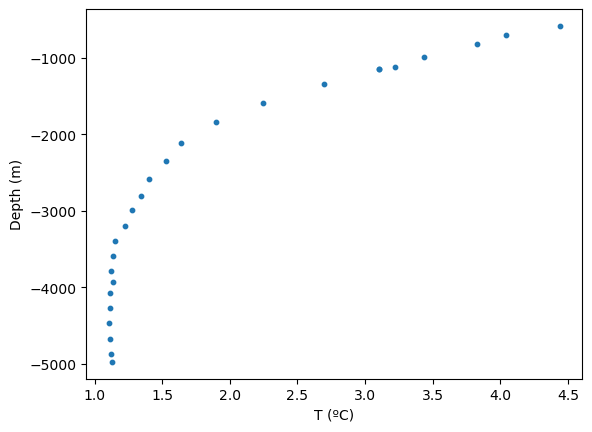

In [2]:
import matplotlib.pyplot as plt

# Temperature measurements extracted from Figure 3 in Munk, 1966
CTD_T = [1.1296296296296295, 1.122004357298475, 1.1143790849673203, 1.1067538126361656, 1.1143790849673203, 1.1143790849673203, 1.1372549019607843, 1.122004357298475, 1.1372549019607843, 1.1525054466230937, 1.2287581699346406, 1.2745098039215685, 1.343137254901961, 1.4041394335511983, 1.526143790849673, 1.6405228758169934, 1.8997821350762527, 2.242919389978214, 2.69281045751634, 3.104575163398693, 3.104575163398693, 3.218954248366013, 3.4324618736383443, 3.8289760348583877, 4.042483660130719, 4.438997821350762]
CTD_z = [-4976.958525345623, -4869.431643625192, -4677.419354838709, -4470.046082949309, -4270.353302611367, -4070.6605222734256, -3932.411674347158, -3786.4823348694317, -3586.78955453149, -3394.7772657450078, -3195.084485407066, -2995.3917050691243, -2803.379416282642, -2580.6451612903224, -2350.230414746544, -2112.1351766513058, -1843.3179723502303, -1597.5422427035332, -1344.0860215053763, -1144.3932411674346, -1144.3932411674346, -1121.351766513057, -990.7834101382491, -821.8125960061443, -698.9247311827958, -583.7173579109067]

plt.scatter(CTD_T,CTD_z,s=10)
plt.xlabel('T (ºC)')
plt.ylabel('Depth (m)')


### 1.2 Abyssal recipes

Munk (1966) proposed that the thermal structure of the ocean interior is set by a balance between upwelling and diffusion. In this view, cold waters sink near the poles and spread across the seafloor before slowly rising through the ocean interior. If we assume, as Munk did, that the water upwells uniformly across the globe, the upwelling speed is approximately $10^{-7}$ m/s. This is far too small to directly measure, but it is large enough to have a major impact on the distribution of tracers. Since light can only penetrate through the top ~100m of ocean, we can ignore solar heating, except in that it sets the temperature near the ocean surface.

### 1.3 Steady advection/diffusion equation

Dedalus can solve differential equations in various forms. In addition to time-dependent initial value problems (IVPs), Dedalus can solve linear and nonlinear boundary value problems. The code below uses Dedalus to solve a linear boundary value problem (IVBP) for the steady state advection/diffusion equation. 

Here, the top and bottom temperature are set from the measured profile and these are used as boundary conditions. The vertical (upwelling) velocity is set to $10^{-7} m/s$, and the diffusivity is set to $10^{-7}$ $m^2/s$, to approximate the molecular diffusivity of heat in seawater. 

2024-12-18 15:07:53,964 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s


Text(0, 0.5, 'Depth (m)')

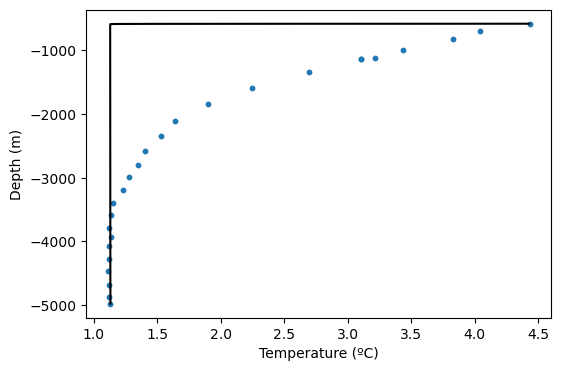

In [3]:
"""
Dedalus script to solve the steady advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature 
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappa=1e-7 # m^2/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.4 Student investigation
<a id='section1pt4'></a>
Note that the profile above is not a good fit to the data. This implies that molecular diffusion isn't sufficient to transport heat down from the surface and stop the ocean from filling up with cold, dense water. 

Munk (1966) proposed that small-scale turbulence in the ocean interior results in a diffusivity that is orders of magnitude larger than the molecular value. Find a diffusivity that gives a good match with the data and test it in the Dedalus script above. Comment on the ability of this model (steady advection/diffusion) to fit the data. 

In [22]:
def profile(kappa,endpoint=-1):
    z_surface = CTD_z[endpoint]
    z_bottom = CTD_z[0]
    T_surface = CTD_T[endpoint]
    T_bottom = CTD_T[0]
    Nz = 1000

    # Set the upwelling velocity
    w = 1e-7 # m/s
    # Set the diffusivity
    

    # Bases
    zcoord = d3.Coordinate('z')
    dist = d3.Distributor(zcoord, dtype=np.float64)
    zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
    z = dist.local_grid(zbasis)

    # Fields
    T = dist.Field(name='T', bases=zbasis)

    # Add two tau variables to allow us to apply two boundary conditions
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)

    # Substitutions
    dz = lambda A: d3.Differentiate(A, zcoord)
    Tz = dz(T) + lift(tau_1)
    Tzz = dz(Tz) + lift(tau_2)

    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - kappa*Tzz = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Plot
    #plt.figure(figsize=(6, 4))
    Tg=T['g']
    plt.scatter(CTD_T,CTD_z,s=10)
    plt.plot(Tg,z, label = f'kappa = {kappa}')
    plt.xlabel(r'Temperature ($\degree$C)')
    plt.ylabel('Depth (m)')
    plt.legend()

2024-12-18 15:13:11,278 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+01/s
2024-12-18 15:13:11,354 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s
2024-12-18 15:13:11,429 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s
2024-12-18 15:13:11,501 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s
2024-12-18 15:13:11,573 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s


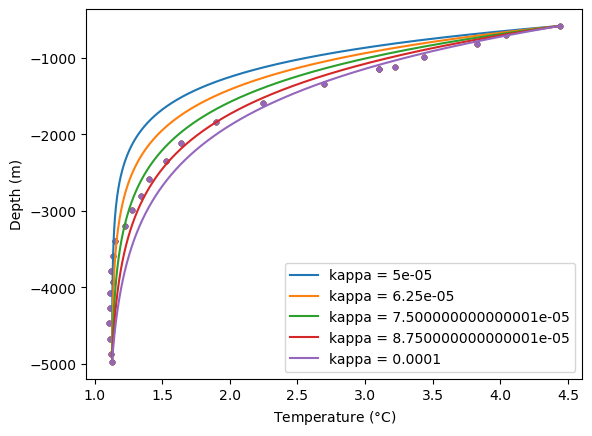

In [23]:
kappas = np.linspace(5*10**-5,10*10**-5,5)
#kappas = 10**(logkappas)
for kappa in kappas:
    profile(kappa)
    


2024-12-18 15:16:03,251 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


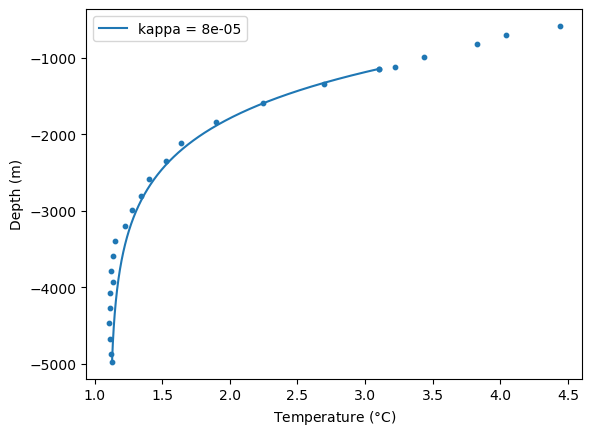

In [25]:
profile(8*10**-5,endpoint = -7)

 ----
 
 Changing the diffusion constant, allows a generally good fit of the data. It seems that in the upper  1.5 km of the ocean the gradient increases again, suggesting a larger mixing than modelled by this constant diffusivity. In the lowest 1.5 km the profile is almost close to vertical, likely also implying an importance of mixing here.
Physical mechanisms could include mixing from seamounts an the bottom. However the middle of the profile is fit very well by diffusivity = $7 * 10^{-5}$ $m^2s^{-1}$ and w = $10^{-7}$ $ms^{-1}$. 

Note tat this diffusivity is an integrated value across the past of the current. For example bottom water that starts off at Antarctica, will not be very mixed. As it progreses towards the equator more mixing occurs, hence meaning the Diffusivity increases. Therefore, the diffusivity is a function of position in the ocean. 

----

### 1.5 Turning ocean mixing upside down

Decades of research to measure the turbulent diffusivity in the ocean consistently found values much smaller than the one predicted by Munk (1966). Specifically, while larger values of the turbulent diffusivity were found near the bottom of the ocean over rough topographic features, the values in the upper ocean were about 10x smaller than the values predicted by Munk. 50 years after Munk's seminal paper, Ferrari et al. (2016) proposed that a depth-dependent turbulent diffusivity could be balanced by <em>downwelling</em>, with negative vertical velocities in the ocean interior. In this theory, the overturning circulation is upwelling in thin boundary layers along the sloping sides of the ocean basins.

When the diffusivity, $\kappa$, is a function of $z$, the steady advection/diffusion equation can be written

$$ w\frac{dT}{dz} = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$

The Dedalus script below solves the previous equation and again compares the results with the observed temperature profile. For the depth-dependent diffusivity, $\kappa(z)$, we take

$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l} $$

using the form from Rogers et al., 2023, where $\kappa_{bg}=1\times 10^{-5} m^2/s$ is the background diffusivity characteristic of the upper water column, $\kappa_0=8.6\times 10^{-4} m^2/s$ characterizes the enhanced mixing near the bottom of the ocean, $D$ is a reference depth where $\kappa=\kappa_0$, and $l=667m$ is an exponential decay scale. In the script below, we start with $w=0$. 

2024-12-18 15:07:55,297 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+00/s


Text(0, 0.5, 'Depth (m)')

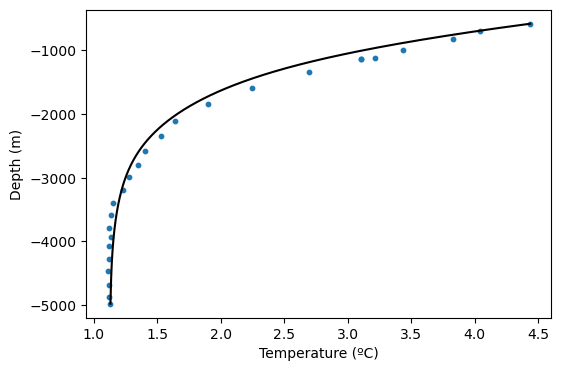

In [7]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature 
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 1*10**(-8) # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)
# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
kappa['g']=1e-5 + (15e-4-1e-5)*np.exp((-5e3-z)/667) # m^2/s

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.6 Student investigation
Note from the results of the script above that the density profile is reasonable, even though $w=0$. In the box below, comment on the balance in this case and what this implies about the diffusive heat flux.

Next, find a vertical velocity that produces a better agreement with the observations and report it below. Then, try varying the details of the $\kappa(z)$ profile. How sensitive is the optimal $w$ to your choice of $\kappa(z)$? What does this imply about the circulation in the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography?



<div style="color: lightblue;">

-----

A value resulting in a sensible profile is $w = 10^{-8} \  ms^{-1}$. An increased roughness of the bottom topography, will potentially increase the bottom mixing ($\kappa_0$) and the lengthscale of decay (l).

An increase in l from 667 to 1000m, makes w increase to approx $1.7 * 10^{-8} \  ms^{-1}$.$\newline$
An increase in ($\kappa_0$) from $8.6* 10^{-4}$ to $10*10^{-4}$, is still fit best by $w = 10^{-8} \  ms^{-1}$. $\newline$
Increasing ($\kappa_0$), makes the rate of change of T larger at the bottom of the ocean, hence w should decrease. However this change is not very sensitive and isn't observed due to the intricacies of the fit discussed in 1.4.


<div style="color: lightblue;">

----


(As an aside, note that the requied vertical velocity is much smaller than the one used by Munk (1966). This implies that the dense, cold water that sinks at the poles must rise elsewhere. Ferrari et al. (2016) proposed that this occurs in boundary layers near the seafloor.)

## 2. Transport of pollution in a river

Advection/diffusion equations are a common way to model the material transport in many physical systems. In this section we will model the transport and dilution of a pollutants added to a river.

For simplicity, we will model the river as a rectangular channel, and we will neglect depth variations. Let $x$ be the coordinate along the length of the river, and $y$ be the cross-stream coordinate. We will model the river current as 

$$ u(y) = U_0\left(1-\frac{(y-w/2)^2}{(w/2)^2}\right) $$

where $w$ is the width of the river and $U_0$ is the maximum current speed which occurs at the center of the river (the $y$-coordinate will run from 0 to $w$).

Since we want to know how the pollution levels vary in time, we will solve the time-dependent advection/diffusion equation. We will model the addition of pollution by adding a spatially-dependent source term to the right hand side of the equation governing pollutant concentration:

$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$

where $\nabla^2=(\partial_x^2 + \partial_y^2)$ is the Laplacian operator for diffusion in 2D Cartesian coordinates, and $S$ is the source term.

### 2.1 Dedalus script

The script below solves the time-dependent advection/diffusion equation with a source term.

In [100]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 0.001 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx) # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='b', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])]; 

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    S0 = 1 # amplitude of the pollution source term
    S_w = 1 # width of the source term in m
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

2024-12-18 16:08:58,594 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s
2024-12-18 16:08:58,596 __main__ 0/1 INFO :: Starting main loop
2024-12-18 16:08:58,621 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e-01, dt=1.953125e-01
2024-12-18 16:08:58,639 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+00, dt=1.953125e-01
2024-12-18 16:08:58,657 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+00, dt=1.953125e-01
2024-12-18 16:08:58,678 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+00, dt=1.953125e-01
2024-12-18 16:08:58,696 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+00, dt=1.953125e-01
2024-12-18 16:08:58,715 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+00, dt=1.953125e-01
2024-12-18 16:08:58,733 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+01, dt=1.953125e-01
2024-12-18 16:08:58,752 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+01, dt=1.953125e-01
2024-12-18 16:08:58,770 __main__ 0/1 INFO :: Iteratio

## 2.2 Visualization

The script below makes a movie of the results from the saved variables. To run this, you need to have ffmpeg installed.  If you don't already have it installed, you can install ffmpeg with the command: 

`conda install -c conda-forge ffmpeg`

2024-12-18 16:09:19,536 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-12-18 16:09:19,537 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpqf5_dkrz/temp.m4v


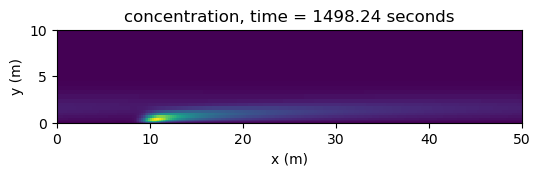

In [101]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))  

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)   
    plt.ylim(0, w)  
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

In [10]:
xx,yy = np.meshgrid(x,y)

In [11]:
np.shape(c_save)

(78, 256, 32)

## 2.3 Student investigation
<a id='section2pt3'></a>
In the boxes below, plot the pollution concentration at a few points as a function of time. Then vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters. Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

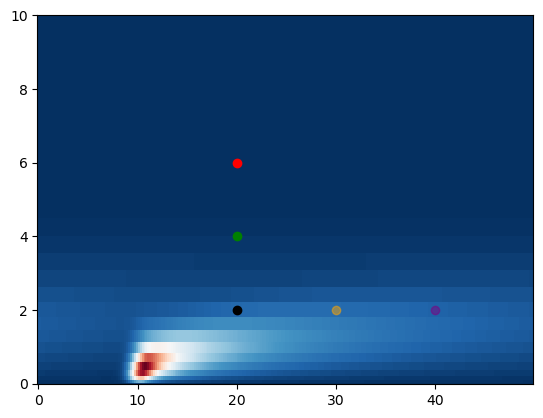

In [120]:
plt.pcolor(xx,yy,c_save[-1].T, cmap='RdBu_r', rasterized=True)
plt.scatter(20,6,c='red')
plt.scatter(20,4,c='green')
plt.scatter(20,2,c='black')

plt.scatter(30,2,c='orange',alpha=0.5)
plt.scatter(40,2,c='purple',alpha=0.5)

In [93]:
def c_variable ( kappa, u_max):

    U0 = u_max # maximum current speed in m/s
    w = 10 # width of the river in m
    L = 50 # length of the river section to simulate
     # diffusivity in m^2/s
    S0 = 1 # amplitude of the pollution source term
    S_w = 1 # width of the source term in m
    S_x = 10 # center of the forcing in x
    S_y = 0 # center of the forcing in y
    S_t = 1 # forcing timescale

    # Numerical parameters
    Nx = 256 # number of gridoints in x
    Ny = 32 # number of gridpoints in y
    stop_sim_time=1500 # end time in seconds
    timestep = (L/Nx) # timestep in seconds, calculated from the CFL number

    import numpy as np
    import dedalus.public as dedalus
    import logging
    logger = logging.getLogger(__name__)

    # Bases and coordinates
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
    ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
    x, y = dist.local_grids(xbasis, ybasis)
    ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

    # Fields
    c = dist.Field(name='b', bases=(xbasis,ybasis))
    u = dist.Field(name='u', bases=(xbasis,ybasis))
    tau_1 = dist.Field(name='tau_1', bases=xbasis)
    tau_2 = dist.Field(name='tau_2', bases=xbasis)

    # Specify the velocity field
    u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

    # Substitutions
    lift_basis = ybasis.derivative_basis(1)
    lift = lambda A: dedalus.Lift(A, lift_basis, -1)
    grad_c = dedalus.grad(c) + ey*lift(tau_1)
    dx = lambda A: dedalus.Differentiate(A, coords['x'])

    S = dist.Field(name='u', bases=(xbasis,ybasis))
    S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

    # Problem
    problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
    problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
    problem.add_equation("c(y=0) = 0")
    problem.add_equation("c(y=w) = 0")

    # Now, set the solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    # Create an array to periodically save the concentration field for plois the tting later
    c.change_scales(1)
    c_save = [np.copy(c['g'])]; 

    t_save = [solver.sim_time]; # Save the initial condition and the initial time
    # Main loop
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration-1) % 10 == 0:
                #logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
                c.change_scales(1)
                c_save.append(np.copy(c['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()

    # Convert the variables to numpy arrays for allow array slicing
    c_save = np.array(c_save)is the 
    return c_save.T

In [96]:
def c_atx(x,y,kappa= 0.001,u0=0.1): #x,y in 'pixel values'
    C_t = c_variable(kappa,u0)
    c_atx = C_t[y,x,:]
    print(np.shape(C_t))
    return c_atx


In [117]:
c1=c_atx(np.array([102,102,102,153,204]),np.array([5,13,21,5,5]),1)

2024-12-18 16:22:26,130 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+00/s
2024-12-18 16:22:26,132 __main__ 0/1 INFO :: Starting main loop
2024-12-18 16:22:38,832 solvers 0/1 INFO :: Simulation stop time reached.
2024-12-18 16:22:38,833 solvers 0/1 INFO :: Final iteration: 7680
2024-12-18 16:22:38,833 solvers 0/1 INFO :: Final sim time: 1500.0
2024-12-18 16:22:38,833 solvers 0/1 INFO :: Setup time (init - iter 0): 0.1917 sec
2024-12-18 16:22:38,834 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.03847 sec
2024-12-18 16:22:38,834 solvers 0/1 INFO :: Run time (iter 10-end): 12.66 sec
2024-12-18 16:22:38,834 solvers 0/1 INFO :: CPU time (iter 10-end): 0.003517 cpu-hr
2024-12-18 16:22:38,835 solvers 0/1 INFO :: Speed: 1.051e+07 mode-stages/cpu-sec
(32, 256, 769)


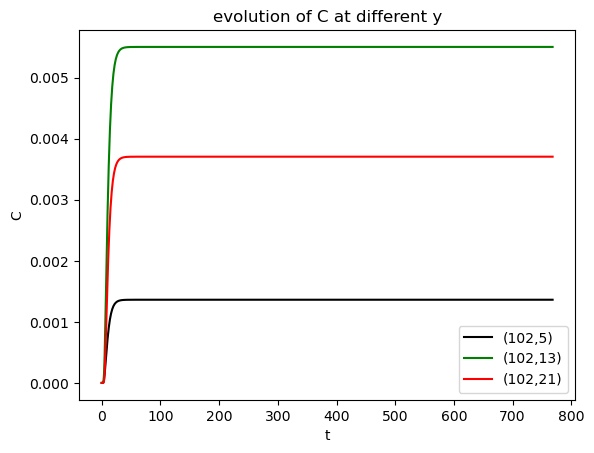

In [110]:
plt.plot(c1[0],label = '(20m,2m)',c='black')
plt.plot(c1[1],label = '(20m,4m)',c='green')
plt.plot(c1[2],label = '(20m,6m)',c='red')
'''
plt.plot(c1[3],label = '(102,5)',c='black')
plt.plot(c1[4],label = '(102,13)',c='green')
plt.plot(c1[5],label = '(102,21)',c='red')
'''

plt.ylabel('C')
plt.xlabel('t')
plt.title('evolution of C at different y' )
plt.legend()

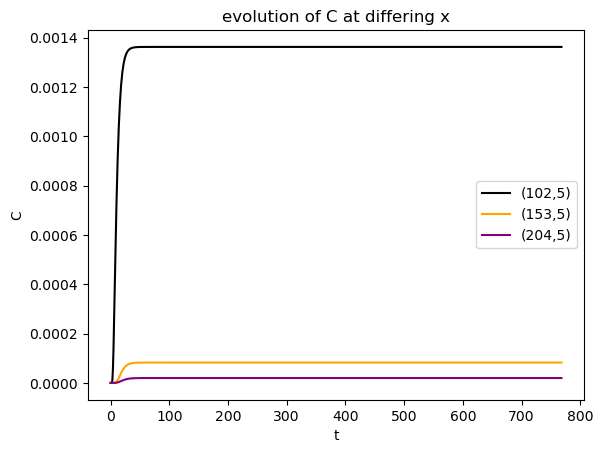

In [119]:
plt.plot(c1[0],label = '(20m,5)',c='black')
plt.plot(c1[3],label = '(20m,5)',c='orange')
plt.plot(c1[4],label = '(20m,5)',c='purple')
'''
plt.plot(c1[3],label = '(20m,5)',c='black')
plt.plot(c1[4],label = '(102,13)',c='green')
plt.plot(c1[5],label = '(102,21)',c='red')
'''

plt.ylabel('C')
plt.xlabel('t')
plt.title('evolution of C at differing x' )
plt.legend()

2024-12-18 16:42:58,577 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+00/s
2024-12-18 16:42:58,579 __main__ 0/1 INFO :: Starting main loop
2024-12-18 16:43:12,619 solvers 0/1 INFO :: Simulation stop time reached.
2024-12-18 16:43:12,619 solvers 0/1 INFO :: Final iteration: 7680
2024-12-18 16:43:12,620 solvers 0/1 INFO :: Final sim time: 1500.0
2024-12-18 16:43:12,620 solvers 0/1 INFO :: Setup time (init - iter 0): 0.1922 sec
2024-12-18 16:43:12,620 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.03564 sec
2024-12-18 16:43:12,621 solvers 0/1 INFO :: Run time (iter 10-end): 14 sec
2024-12-18 16:43:12,621 solvers 0/1 INFO :: CPU time (iter 10-end): 0.00389 cpu-hr
2024-12-18 16:43:12,621 solvers 0/1 INFO :: Speed: 9.498e+06 mode-stages/cpu-sec
(32, 256, 769)
2024-12-18 16:43:12,860 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.6e+00/s
2024-12-18 16:43:12,862 __main__ 0/1 INFO :: St

Text(0.5, 1.0, 'Solid line - Kappa = 0.01, Dashed line = 0.1')

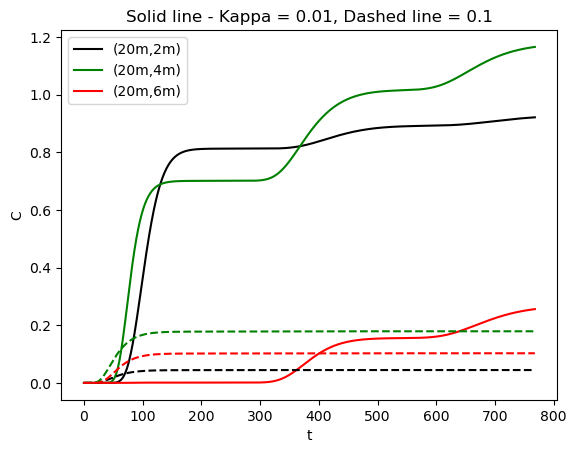

In [124]:
#changing kappa
c1=c_atx(np.array([102,102,102]),np.array([5,13,21]),0.01,0.1)


plt.plot(c1[0],label = '(20m,2m)',c='black')
plt.plot(c1[1],label = '(20m,4m)',c='green')
plt.plot(c1[2],label = '(20m,6m)',c='red')
plt.legend()

c2=c_atx(np.array([102,102,102]),np.array([5,13,21]),0.1,0.1)

plt.plot(c2[0],label = '(20m,5)',c='black',ls='--')
plt.plot(c2[1],label = '(20m,13)',c='green',ls='--')
plt.plot(c2[2],label = '(20m,21)',c='red',ls='--')

plt.ylabel('C')
plt.xlabel('t')

plt.title('Solid line - Kappa = 0.01, Dashed line = 0.1')

2024-12-18 16:36:49,497 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+00/s
2024-12-18 16:36:49,499 __main__ 0/1 INFO :: Starting main loop
2024-12-18 16:37:02,912 solvers 0/1 INFO :: Simulation stop time reached.
2024-12-18 16:37:02,912 solvers 0/1 INFO :: Final iteration: 7680
2024-12-18 16:37:02,913 solvers 0/1 INFO :: Final sim time: 1500.0
2024-12-18 16:37:02,913 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2039 sec
2024-12-18 16:37:02,913 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.03792 sec
2024-12-18 16:37:02,914 solvers 0/1 INFO :: Run time (iter 10-end): 13.37 sec
2024-12-18 16:37:02,914 solvers 0/1 INFO :: CPU time (iter 10-end): 0.003715 cpu-hr
2024-12-18 16:37:02,914 solvers 0/1 INFO :: Speed: 9.945e+06 mode-stages/cpu-sec
(32, 256, 769)
2024-12-18 16:37:03,132 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+00/s
2024-12-18 16:37:03,134 __main__ 0/1 INFO :

Text(0.5, 1.0, 'Solid line - u=0.1, Dashed line - u=0.5')

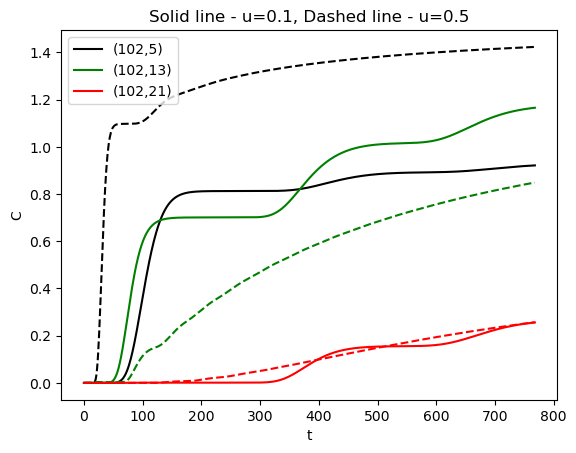

In [123]:
c1=c_atx(np.array([102,102,102]),np.array([5,13,21]),0.01,0.1)


plt.plot(c1[0],label = '(20m,2m)',c='black')
plt.plot(c1[1],label = '(20m,4m)',c='green')
plt.plot(c1[2],label = '(20m,6m)',c='red')
plt.legend()

c2=c_atx(np.array([102,102,102]),np.array([5,13,21]),0.01,0.5)

plt.plot(c2[0],label = '(102,5)',c='black',ls='--')
plt.plot(c2[1],label = '(102,13)',c='green',ls='--')
plt.plot(c2[2],label = '(102,21)',c='red',ls='--')


plt.ylabel('C')
plt.xlabel('t')
plt.title('Solid line - u=0.1, Dashed line - u=0.5')


A larger diffusivity means more of the pollutant moves towards the center of the stream. Given a large enough difussivity, the diffusion occurs faster than the advection, in which case no steps are seen as the concentration becomes very diffuse away from the source. In countrast, a very small diffusivity, will mean that the path of the contaminant is mainy govrened by the advection, and it travels as a blob allong the edge of the river.

The time to reach the other side of the river is the diffusion timescale (as that is the the only process tat allows travel in the y direction). This is $\Tau = \frac{w^2}{\Kappa}$ for w = river width. Therefore an ok estimate of the distance traveled allong the river is distance $=  \frac{w^2}{\Kappa} * U_0$ (this may be an overestimate as the velocity is slower nearer the banks).

For the initial numbers of $\Kappa = 0.01$ and $U_0 = 0.1 ms^{-1}$ the distance is 1000m



-----


In the proble discussed there are two mainvariable that choose the behaviour, the diffusivity and the maximum velocity of the river. For any appreciable velocity, the diffusion is much slower than advection. Therefore, the majority of the transport in the x direction in the middle of the river occurs by advection. Meanwhile the only process that can traspot concentration in the y direction is the diffusion.

Varying diffusivity $\newline$
Increasing we observe that the highest concentration (of the three points selected) changes. With a small diffusivity most of the pollutant remained near the edge of the river, hence meaning that the point 2m from the bank had the largest concentration. In contrast when diffusiity was increased to 0.1, the point at 4m had the highest concentration. (Note te weird step patterns are purely from the boundary conditions and hence may be ignored)

Varying velocity $\newline$
Instead if we increase velocity, we see that the y value of the maximum concentration decreases, and shifts closer towards the river bank. this is the opposite effect, as by increasing velocity, the diffusion has less time to act and hence less distance is coveredin the y dirrection.

Overall therefore the main parameter in the shape of the observed concetration is diffusivity/velocity (or vice-versa)


Scaling $\newline$
As noted above, the only transport in the y direction is from the diffusion, hence the applicable timescale for pollutant crossing the river is that of diffusion. $\Tau = \frac{w^2}{\Kappa}$, for river of width w.
Assuming Advection is ominant in the x direction that yields a distance $=  \frac{w^2}{\Kappa} * U_0$ (this may be an overestimate as the fastest velocity was used.)

For the initial numbers of $\Kappa = 0.01$ and $U_0 = 0.1 ms^{-1}$ the timescale is 10000s and the distance is 1000m.





In [173]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 1000 # length of the river section to simulate
kappa = 0.01 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=10000 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='b', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])]; 

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    S0 = 1 # amplitude of the pollution source term
    S_w = 1 # width of the source term in m
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

2024-12-18 17:36:38,886 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.1e+00/s
2024-12-18 17:36:38,888 __main__ 0/1 INFO :: Starting main loop
2024-12-18 17:36:38,914 __main__ 0/1 INFO :: Iteration=1, Time=3.906250e+01, dt=3.906250e+01
2024-12-18 17:36:38,932 __main__ 0/1 INFO :: Iteration=11, Time=4.296875e+02, dt=3.906250e+01
2024-12-18 17:36:38,951 __main__ 0/1 INFO :: Iteration=21, Time=8.203125e+02, dt=3.906250e+01
2024-12-18 17:36:38,970 __main__ 0/1 INFO :: Iteration=31, Time=1.210938e+03, dt=3.906250e+01
2024-12-18 17:36:38,991 __main__ 0/1 INFO :: Iteration=41, Time=1.601562e+03, dt=3.906250e+01
2024-12-18 17:36:39,011 __main__ 0/1 INFO :: Iteration=51, Time=1.992188e+03, dt=3.906250e+01
2024-12-18 17:36:39,030 __main__ 0/1 INFO :: Iteration=61, Time=2.382812e+03, dt=3.906250e+01
2024-12-18 17:36:39,049 __main__ 0/1 INFO :: Iteration=71, Time=2.773438e+03, dt=3.906250e+01
2024-12-18 17:36:39,068 __main__ 0/1 INFO :: Iteratio

In [174]:
np.shape(c_save[:,:,-1])

(27, 256)

In [175]:
len(t_save)

27

In [176]:
c_save[2,:,-1]

array([-9.24512674e-10,  1.05047813e-09, -2.07799619e-09, -2.03774270e-09,
        9.22926611e-10,  3.42942639e-08,  3.41508406e-07,  1.66220902e-06,
        4.76634866e-06,  8.67027759e-06,  9.55982685e-06,  6.55883448e-06,
        3.05334608e-06,  1.04084376e-06,  2.80841199e-07,  6.00695245e-08,
        1.28105473e-08,  7.59563456e-10,  1.31158991e-09, -9.06529055e-10,
        8.73328460e-10, -8.04044257e-10,  7.49222183e-10, -7.00906095e-10,
        6.58541484e-10, -6.21060563e-10,  5.87682790e-10, -5.57775947e-10,
        5.30828866e-10, -5.06424168e-10,  4.84218084e-10, -4.63924945e-10,
        4.45305976e-10, -4.28159997e-10,  4.12316386e-10, -3.97629602e-10,
        3.83974915e-10, -3.71244336e-10,  3.59344790e-10, -3.48194810e-10,
        3.37723276e-10, -3.27867760e-10,  3.18573123e-10, -3.09790527e-10,
        3.01476729e-10, -2.93592975e-10,  2.86104996e-10, -2.78981532e-10,
        2.72194886e-10, -2.65719913e-10,  2.59534024e-10, -2.53616508e-10,
        2.47948755e-10, -

In [181]:
np.where(c_save[:,:,-1]>1e-5)

(array([ 3,  3,  3, ..., 26, 26, 26]), array([10, 11, 12, ..., 60, 61, 62]))

In [183]:
(L/Nx)/U0 *3

117.1875

## 3. Optional further investigations

* In the river pollution example, you might notice that the concentration field is mixed more effectively in the x-direction than in the y-direction. The combination of differential advection by the currents and cross-stream diffusion is very effective at mixing the plume in the x-direction. This is an example of Taylor dispersion (Taylor, 1953). Construct numerical experiments to quantify Taylor dispersion and its dependence on the current shear and the diffusivity. You could also separate the diffusivity into parts in the x and y directions with different coefficients.  If you set the x-component of the diffusivity to zero, then any spreading of the concentration in the x-direction should be due to Taylor dispersion.

* Try making the river speed a function of time. The easiest way to do this is to add a new equation so that Dedalus solves for the velocity in addition to the concentration field. For example, you could make the river speed decrease exponentially in time, or it could be sinusoidal in time.

* In the ocean mixing example, if $\kappa$ is a function of $x$ and $z$, what would this imply about the velocity field? You could even try writing a Dedalus script to solve the 2D advection/diffusion equation with a prescribed spatially-dependent $\kappa(x,z)$.


### References

Munk, W.H., 1966. Abyssal recipes. In Deep sea research and oceanographic abstracts (Vol. 13, No. 4, pp. 707-730). Elsevier.

Ferrari, R., Mashayek, A., McDougall, T.J., Nikurashin, M. and Campin, J.M., 2016. Turning ocean mixing upside down. Journal of Physical Oceanography, 46(7), pp.2239-2261.

Taylor, G.I., 1953. Dispersion of soluble matter in solvent flowing slowly through a tube. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 219(1137), pp.186-203.